In [1]:
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

In [2]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

In [3]:
!ls

csv_data101	Documents	model_parameters.pth		  one_more_dir
csv_data102	Downloads	model_parameters.pth_c_model.pth  Pictures
csv_dataMANI1	early_hist.txt	model_parameters.pth_r_model.pth  Public
deleteme.ipynb	frogs_project	model_parameters.pth_x_model.pth  Templates
Desktop		histories	Music				  Videos


In [4]:
opt_data = {}
for i in range(24):
#     with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
    with open(f'{ROOT_PATH}/results/sweek_with_shiftMAE_{i}.pkl','rb') as f:
        opt_data[i] = pickle.load(f)

/tmp/ipykernel_3710869/2220721299.py:5: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  opt_data[i] = pickle.load(f)
/tmp/ipykernel_3710869/2220721299.py:5: DeprecationWarning: Please use `LbfgsInvHessProduct` from the `scipy.optimize` namespace, the `scipy.optimize.lbfgsb` namespace is deprecated.
  opt_data[i] = pickle.load(f)


In [5]:
opt_data

{0: {'MAE':                     message: ['requested number of basinhopping iterations completed successfully']
                          fun: 6.937018161397665
                            x: [-4.706e+00  4.589e-02  3.354e-01  3.845e+01]
                          nit: 100
        minimization_failures: 7
                         nfev: 22915
                         njev: 4583
   lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                                success: True
                                 status: 0
                                    fun: 6.937018161397665
                                      x: [-4.706e+00  4.589e-02  3.354e-01
                                           3.845e+01]
                                    nit: 6
                                    jac: [ 0.000e+00  9.400e-01  8.191e+00
                                          -1.143e-01]
                                   nfev: 210
                                   nje

In [6]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}
fixed_params['model'] =  dict(n_inputs = 3,
        n_hidden = 5*4*512,
        n_outs = 1,
        en_bias = False,
        b_high=3, first_layer_init='ones',
        first_layer_weights_trainable = True,
        out_layer_init='zeros')         

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,1,0], 'sigma_noi':0.0, 'tau_u':1,
                        'save_model_at_init':False, 'ic_param_file':None, 'noise_spec':{'noi_x':0.05}
                        }

optim_param_mapping= [('custom','normalized_log_lr'),
                    ('model','skip_gain'),                      
                    ('custom','w'),
                    ('postprocessing','scale'),
                    ]

custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                            'fun': lambda x: 10.**x['normalized_log_lr']/x['w']},
                            {'cathegory':'model','param_name':'nl','fun': lambda x: (lambda : OneOverSqr(w=x['w']))}]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [7]:
df = pd.read_csv(f'{ROOT_PATH}/../../frogs_project/data/avraham__ivry_fig1_rotFig1_v2.csv',header=None)
df = df.T
data = df.to_numpy()

In [ ]:
# stimulus = [(1,40),(0,40)]
pooling_fun = 'MAE'

In [9]:
errors = [opt_data[k][pooling_fun]['fun'] for k in opt_data]


In [50]:
stimulus = [(1,40),(0,40),(1,41)]

In [ ]:
outs  = {k: wrapped_runner(stimulus,opt_data[k][pooling_fun]['x']) for k in opt_data}

In [51]:
trials = 20
outs_mult = {k: [wrapped_runner(stimulus,opt_data[k][pooling_fun]['x'])   for _ in range(trials)]  for k in opt_data} 

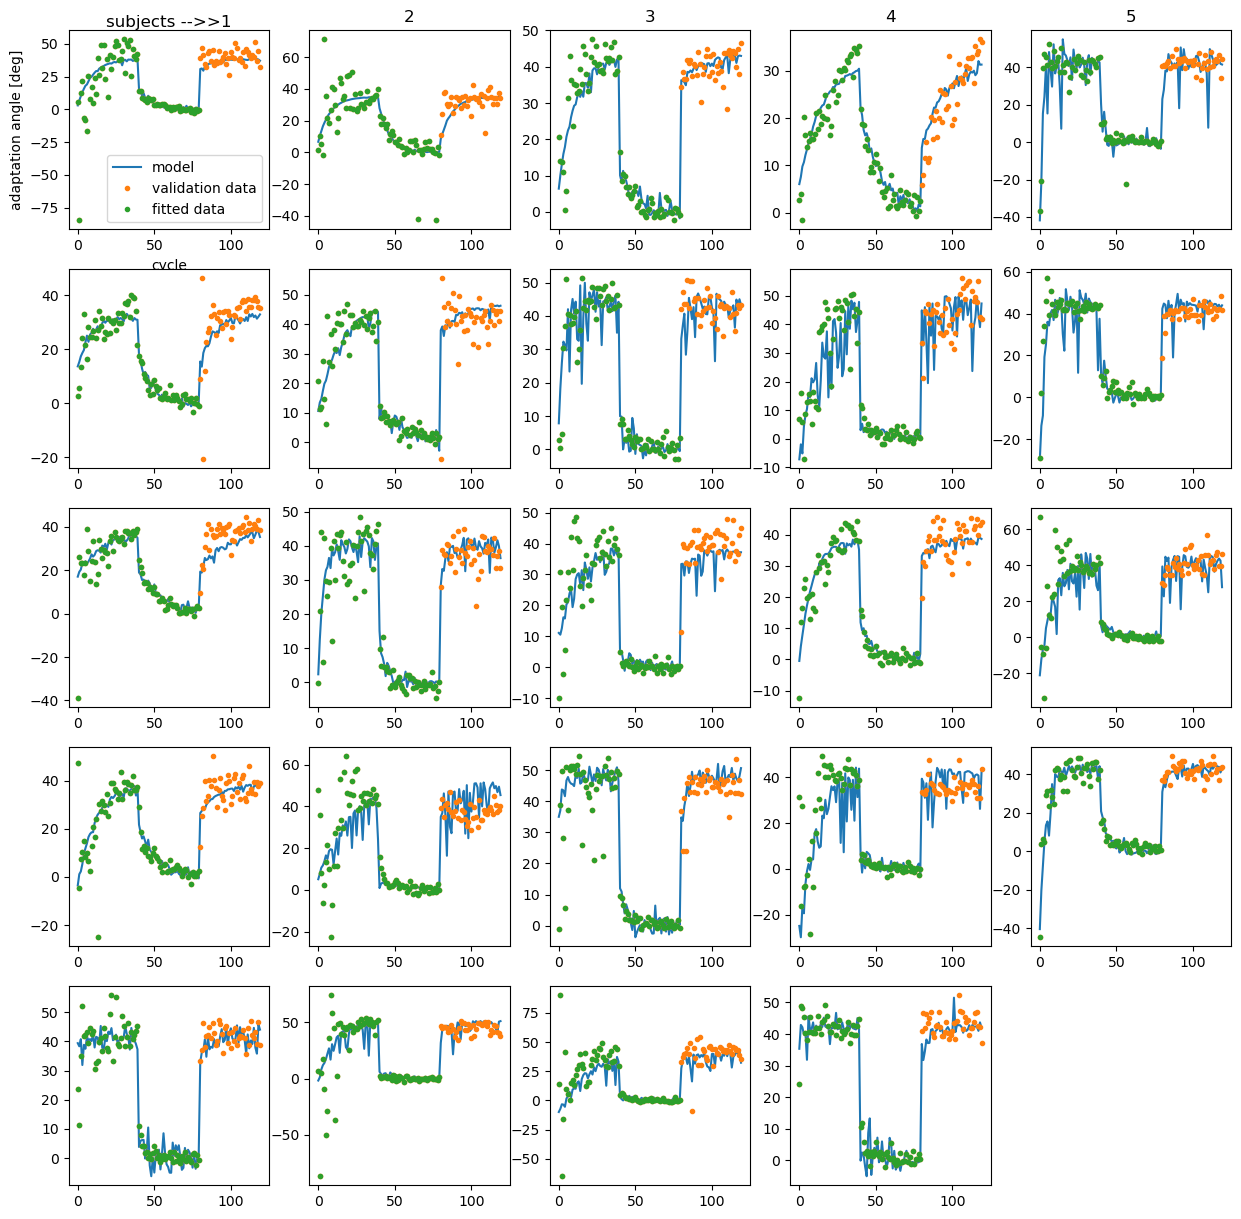

In [12]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k][1:])
    plt.plot(data[:,k],'.')
    plt.plot(data[:80,k],'.')
    if k<5: plt.title(f'{k+1}')
        

plt.subplot(5,5,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)
plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


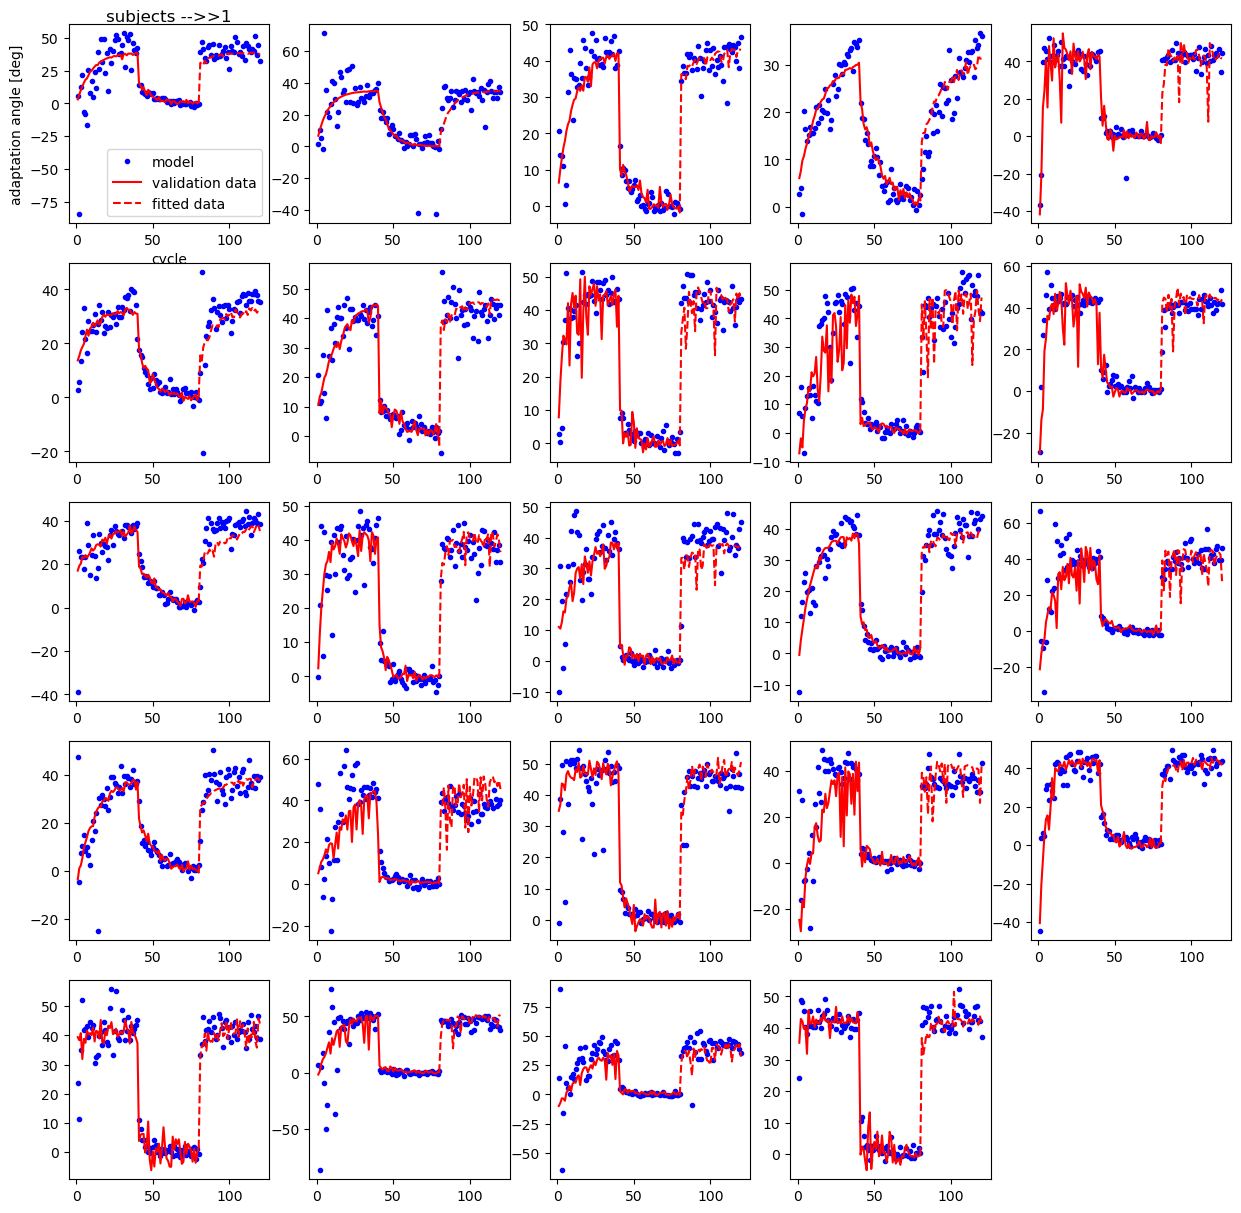

In [ ]:
    
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    ydata_model_train = outs[k][1:81]
    ydata_model_test = outs[k][80:]
    ydata_experiment = data[:,k]
    xdata_model_train = np.arange(1,81)
    xdata_model_test = np.arange(80,121)
    xdata_experiment = np.arange(1,121)
    plt.plot(xdata_experiment,ydata_experiment,'b.')
    plt.plot(xdata_model_train,ydata_model_train,'r-')
    plt.plot(xdata_model_test,ydata_model_test,'r--')
    # np.savetxt(f'{ROOT_PATH}/results/avraham_subj_{k+1}_model_train.csv', np.array([xdata_model_train,ydata_model_train]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/avraham_subj_{k+1}_model_test.csv', np.array([xdata_model_test,ydata_model_test]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/avraham_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')

    # plt.plot(outs[k][1:])
    # plt.plot(data[:,k],'.')
    # plt.plot(data[:80,k],'.')
    # if k<5: plt.title(f'{k+1}')
        

plt.subplot(5,5,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)
plt.legend(['model','validation data','fitted data'])  



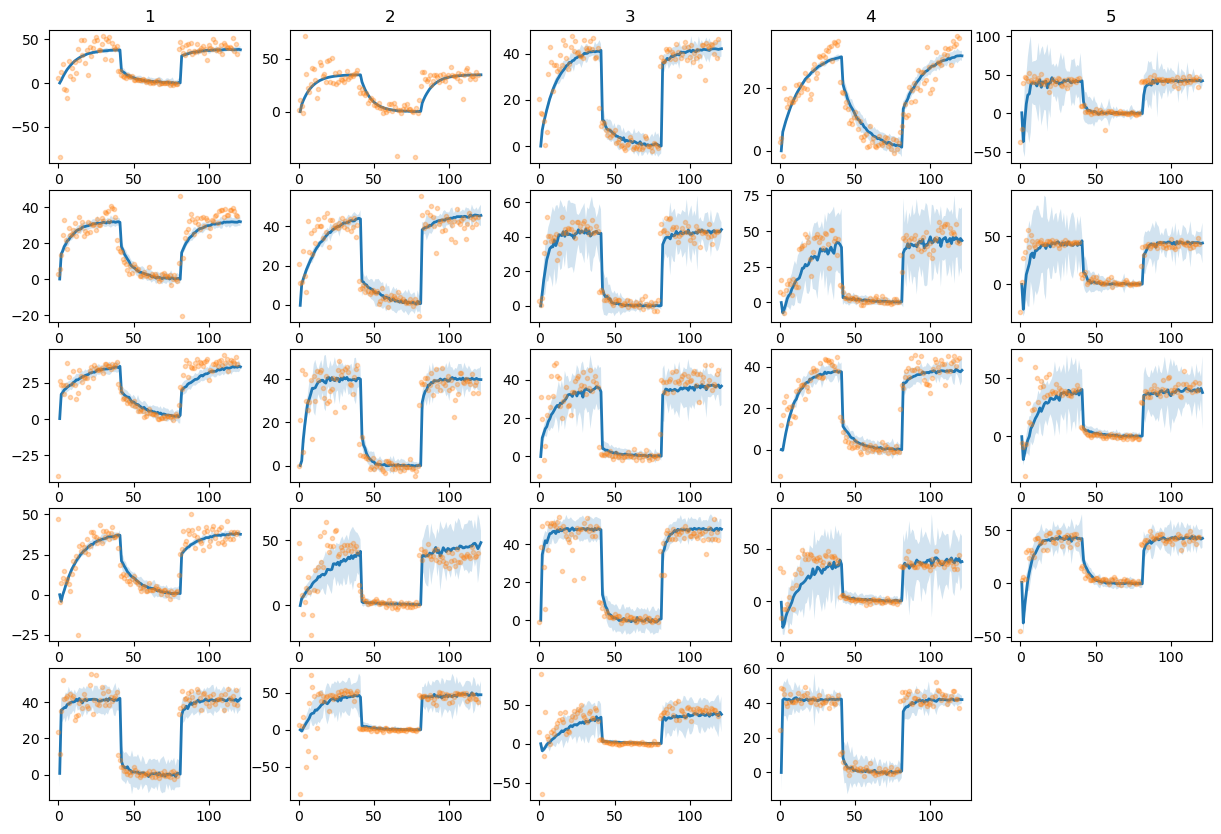

In [55]:
fit_std_N = []
fit_std_A = []
data_std_N = []
data_std_A = []
rms = lambda x: np.sqrt(np.mean(x**2))


plt.figure(figsize=(15,10))
for k in opt_data:
    plt.subplot(5,5,k+1)
    ydata_model_mean = np.mean(outs_mult[k], axis=0)
    ydata_model_std = np.std(outs_mult[k], axis=0)
    xdata_model = np.arange(1,len(ydata_model_mean)+1)
    ydata_experiment = data[:,k]
    xdata_experiment = np.arange(1,len(ydata_experiment)+1)
    #remove nans
    xdata_model = xdata_model[~np.isnan(ydata_model_mean)]
    ydata_model_mean = ydata_model_mean[~np.isnan(ydata_model_mean)]
    ydata_model_std = ydata_model_std[~np.isnan(ydata_model_mean)]

    ydata_experiment = ydata_experiment[~np.isnan(ydata_experiment)]

    fit_std_A.append(rms(ydata_model_std[29:39]))
    fit_std_N.append(rms(ydata_model_std[29+40:39+40]))
    data_std_A.append(np.std(ydata_experiment[29:39]))
    data_std_N.append(np.std(ydata_experiment[29+40:39+40]))


    # output as csv
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_model.csv', np.array([xdata_model,ydata_model]).T, delimiter=',')
    # np.savetxt(f'{ROOT_PATH}/results/coin_fit12_subj_{k+1}_experiment.csv', np.array([xdata_experiment,ydata_experiment]).T, delimiter=',')
    k_draw = 3
    plt.plot(xdata_model,ydata_model_mean,linewidth=2)
    plt.fill_between(xdata_model, ydata_model_mean - k_draw*ydata_model_std, ydata_model_mean + k_draw*ydata_model_std, alpha=0.2)


    plt.plot(ydata_experiment,'.', alpha=0.3)
    if k<5: plt.title(f'{k+1}')
    # plt.text(0.0, 0.1, f'{paradigm_by_id_lut[k]} {k%8+1}', 
    #              horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12,
    #              bbox=dict(facecolor='orange', alpha=0.3))



# plt.subplot(4,4,1)
# plt.ylabel('adaptation angle [deg]')
# plt.xlabel('cycle')

# plt.gca().set_title(f'subjects -->>{1}', pad=-30)

In [62]:
fit_std_A = np.array(fit_std_A)
fit_std_N = np.array(fit_std_N)
data_std_A = np.array(data_std_A)
data_std_N = np.array(data_std_N)
rANfit = fit_std_A/fit_std_N
rANdata = data_std_A/data_std_N

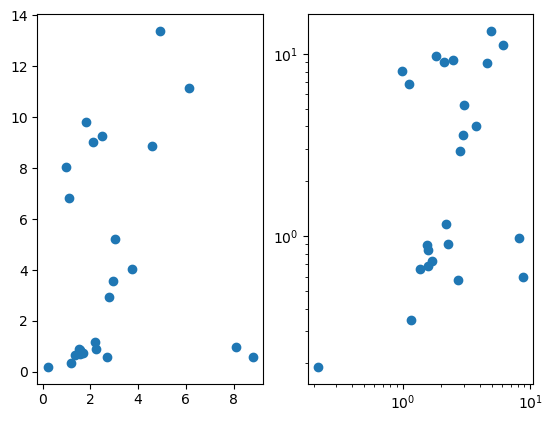

In [64]:
plt.figure()
plt.subplot(121)
plt.plot(rANdata, rANfit, 'o')
plt.subplot(122)
plt.loglog(rANdata, rANfit, 'o')


In [67]:
from scipy.stats import pearsonr, spearmanr

In [70]:
pear_loglog = pearsonr(np.log(rANdata), np.log(rANfit))
pear = pearsonr(rANdata, rANfit)
spear = spearmanr(rANdata, rANfit)
print(f'Pearson correlation (log-log): {pear_loglog[0]:.3f}, p-value: {pear_loglog[1]:.3f}')
print(f'Pearson correlation (linear): {pear[0]:.3f}, p-value: {pear[1]:.3f}')
print(f'Spearman correlation: {spear[0]:.3f}, p-value: {spear[1]:.3f}')

Pearson correlation (log-log): 0.366, p-value: 0.079
Pearson correlation (linear): 0.154, p-value: 0.473
Spearman correlation: 0.350, p-value: 0.093


Text(0.1, 0.7, 'Spearman: 0.350, p=0.093')

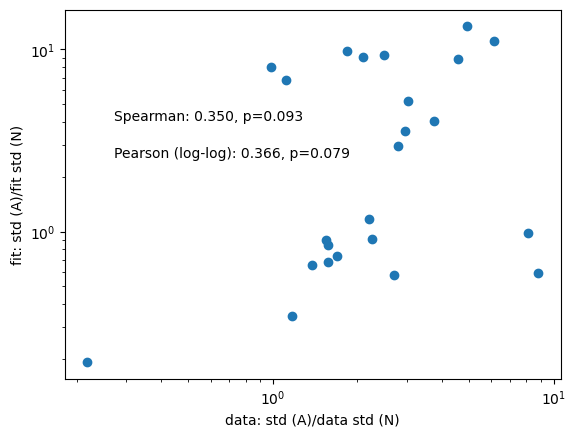

In [73]:
plt.loglog(rANdata, rANfit, 'o')
plt.xlabel('data: std (A)/data std (N)')
plt.ylabel('fit: std (A)/fit std (N)')
plt.text(0.1, 0.6, f'Pearson (log-log): {pear_loglog[0]:.3f}, p={pear_loglog[1]:.3f}', transform=plt.gca().transAxes)
plt.text(0.1, 0.7, f'Spearman: {spear[0]:.3f}, p={spear[1]:.3f}', transform=plt.gca().transAxes)

In [14]:
# xdata_experiment.shape,ydata_experiment.shape
xdata_model_train.shape,ydata_model_train.shape

((80,), (80,))

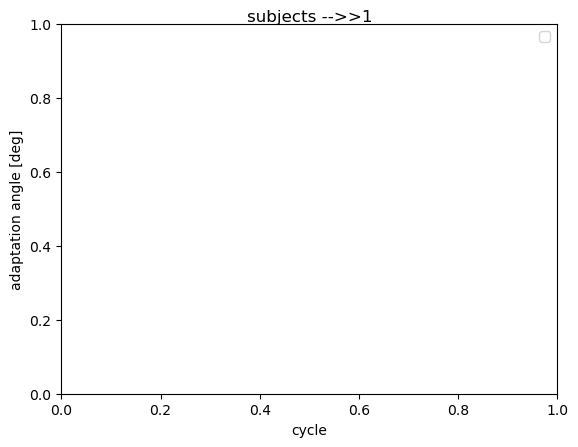

In [15]:
plt.subplot(1,1,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-3000)
plt.legend(['model','validation data','fitted data']) 

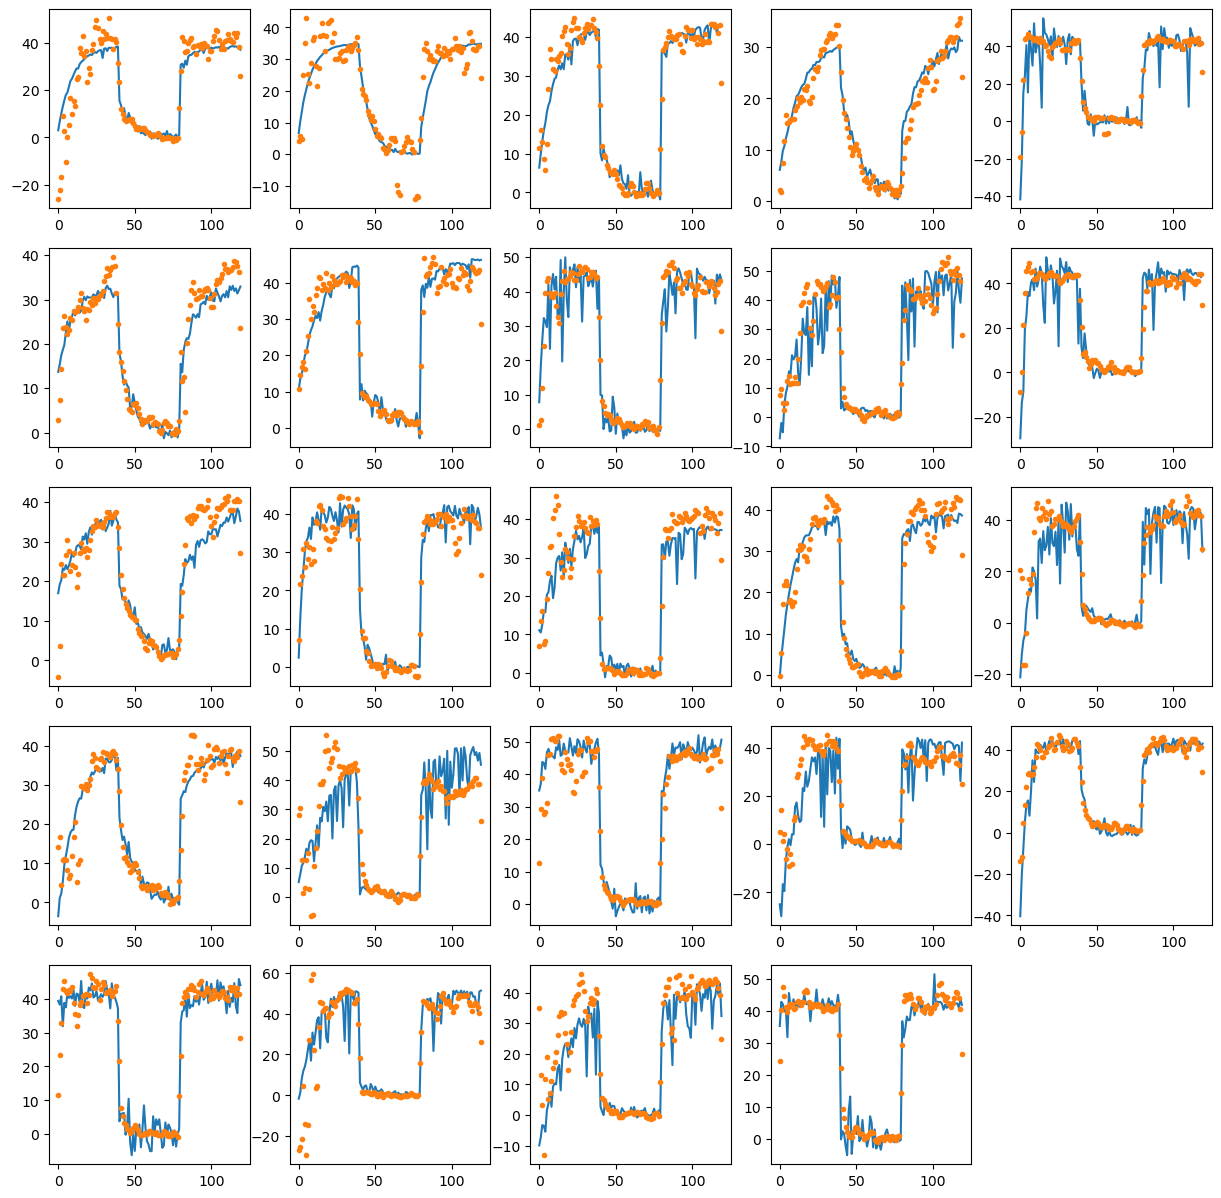

In [16]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k][1:])
    plt.plot(smooth_signal(data[:,k],3),'.')

In [17]:
outs_ = [o[1:] for _,o in outs.items()]
outs_ = np.array(outs_)

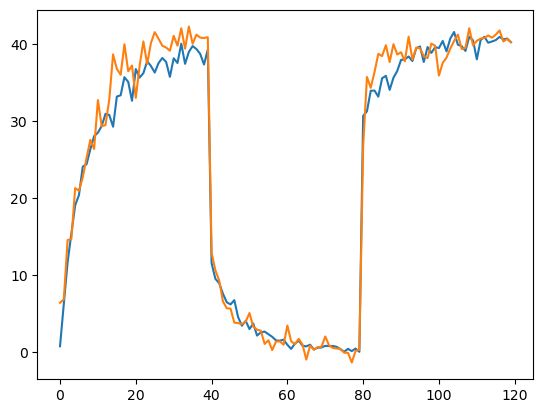

In [18]:
plt.plot(np.mean(outs_,axis=0))
plt.plot(np.mean(data,axis=1))

In [19]:
diffs = outs_.T-data
np.mean(diffs[:80,:]**2),np.mean(diffs[80:,:]**2)

(95.79467096400701, 53.04846854500027)

In [20]:
data_varia = data-np.mean(data,axis=1,keepdims=True)

In [21]:
np.mean(data_varia**2)

83.27901569878472

In [22]:
np.mean(diffs[:80,:]**2),np.mean(diffs[80:,:]**2),np.mean(diffs[81:,:]**2)

(95.79467096400701, 53.04846854500027, 49.490709906676365)

In [23]:
np.mean(data_varia[:80,:]**2),np.mean(data_varia[80:,:]**2),np.mean(data_varia[81:,:]**2)

(99.77897536675346, 50.27909636284723, 46.55323259882478)

[]

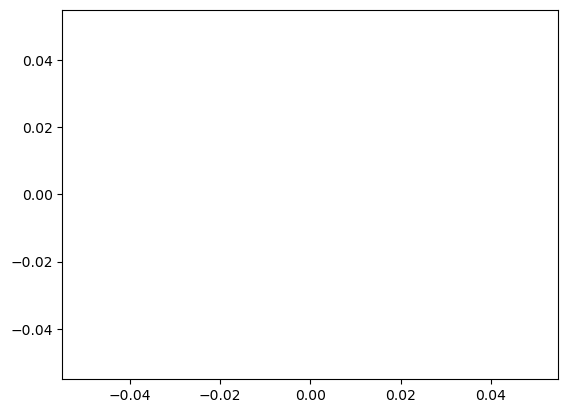

In [24]:
plt.plot(diffs[:,80:])

In [25]:
A_times = [0,5,10,20] 
antero   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}

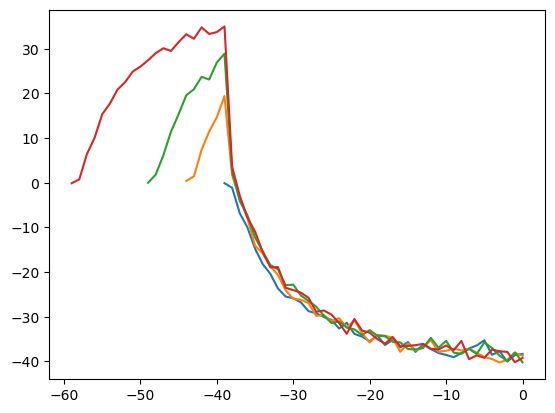

In [26]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    

In [27]:
frog_ens = [True,False]
Tfrog = 220
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

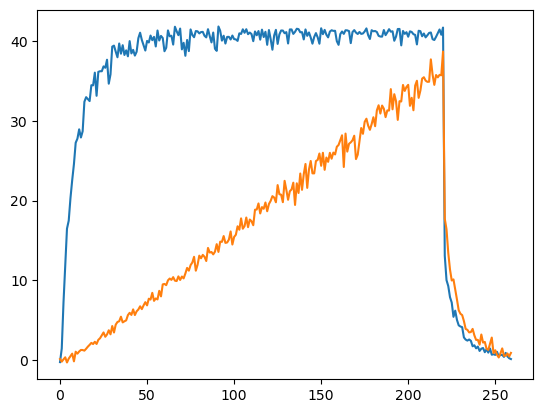

In [28]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [29]:
mae = lambda x: np.mean(np.abs(x))
mse = lambda x: np.mean(np.square(x))


In [30]:
for setting in pooling_funs +[appendix]:
    fit_err = outs[setting][:80] - data[:80,0]
    val_err = outs[setting][80:] - data[80:,0]
    print(f'fit objective: {setting}')
    print(f' fitting MAE: {mae(fit_err)}; MSE: {mse(fit_err)}')
    print(f' validation MAE: {mae(val_err)}; MSE: {mse(val_err)}')

NameError: name 'pooling_funs' is not defined

In [ ]:
import scipy
scipy.__version__

In [ ]:
# !pip3 install --upgrade pip

In [ ]:
# pip install --upgrade scipy

In [ ]:
import pickle

In [ ]:
with open('sweep_1_subj_12.pkl','rb') as f:
    opt_data = pickle.load(f)

In [ ]:
opt_data